# ENCH 470 Spring 2024 Lecture 9: Train and Test sets



## Creating and inspecting Training and Testing datasets

First, we need to split our data into a training set and a test set. For 6031 molecules, let's put 90% (5428) in the training set, and 10% (603) in the test set.

The *right* way to do this is to select them at random. One way is pulling out 5428 using the DataFrame method `sample`. Then, put the rest of the data in Test.
(I got the lines for defining Test from [here](https://stackoverflow.com/questions/28901683/pandas-get-rows-which-are-not-in-other-dataframe))

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

ThermoProperties = pd.read_csv('ThermoProperties.csv')

Train = ThermoProperties.sample(n=5428, random_state=0)
Test = ThermoProperties[~ThermoProperties.index.isin(Train.index)]
# Thanks StackExchange!

# Don't forget, you can use train_test_split from scikit-learn, too

**<font color=red>Problem:</font>** We want to make sure the training and test set are balanced (i.e., they are sampled from the same distribution), but it's hard to be sure from the scatter plot.

Make a 2 x 2 figure of 4 histograms to show 1) the distribution of molecular weight in the training and test sets, and 2) the distribution of critical temperature in the training and test sets.

Put the training sets on the bottom and the test sets on the top, and molecular weight on the left and the critical temperatures on the right.

Be sure to add axis labels and titles as appropriate.

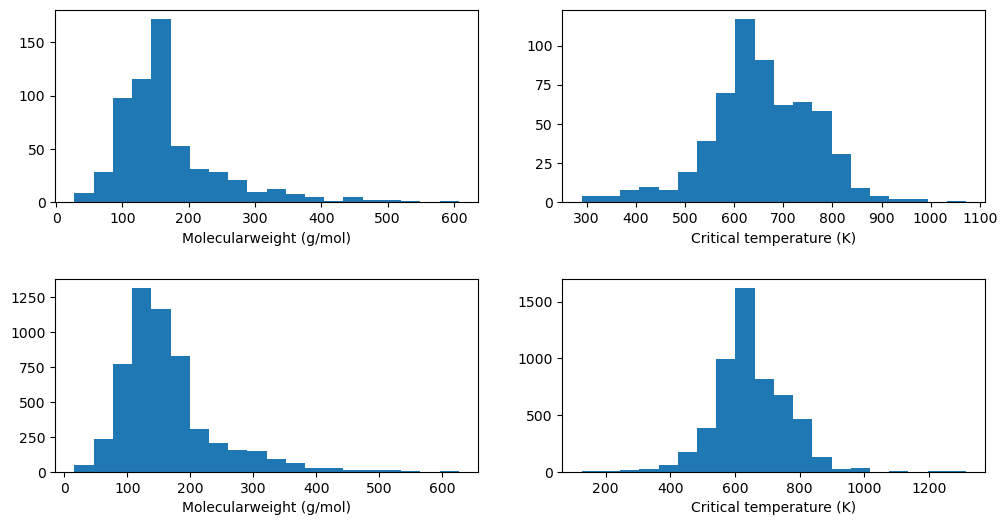

In [16]:
# This will get you started working with multiple subplots
fig, ax = plt.subplots(2,2, figsize=(12,6))
plt.subplots_adjust(wspace=0.2, hspace=0.4)

ax[0,0].hist(Test['molweight'], bins=20)
ax[0,1].hist(Test['critical temperature (K)'], bins=20)
ax[1,0].hist(Train['molweight'], bins=20)
ax[1,1].hist(Train['critical temperature (K)'], bins=20)
ax[0,0].set_xlabel('Molecularweight (g/mol)')
ax[0,1].set_xlabel('Critical temperature (K)')
ax[1,0].set_xlabel('Molecularweight (g/mol)')
ax[1,1].set_xlabel('Critical temperature (K)')


plt.show()

### Training / testing split without being careful

What if we didn't pick these at random? For example, we might put the first (alphabetically) 5428 molecules in the training set and the last 603 molecules in the test set.

### Splitting data to build models for extrapolation

If we specifically aimed to build models for extrapolating, we would divide our data differently. In this case, you could set aside the 200 highest-molecular weight molecules for **validation**, and divide the remaining dataset into 90% training and 10% testing.

**<font color=red>Problem:</font>** Pick **one** of the above cases (alphabetical split or splitting for extrapolation), and repeat problem 1 (slice and make plot with histograms). The first (alphabetical) is easier than the second. I recommend naming variables differently than in the next example to avoid overwrites.

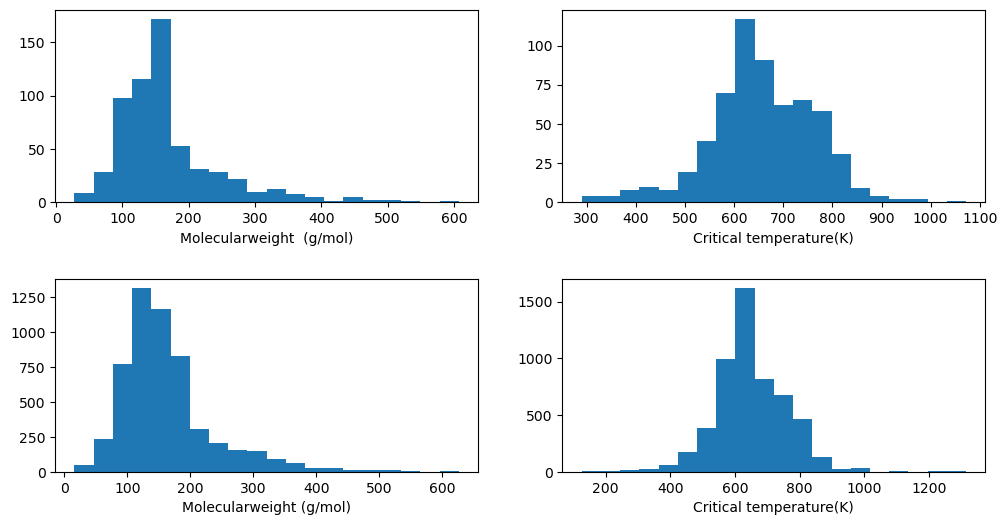

In [73]:
Validation= ThermoProperties.nlargest(200,'molweight')
newvalidation = ThermoProperties[~ThermoProperties.index.isin(Validation.index)]
Train = ThermoProperties.sample(n=5427, random_state=0)
Test = ThermoProperties[~ThermoProperties.index.isin(Train.index)]

fig, ax = plt.subplots(2,2, figsize=(12,6))
plt.subplots_adjust(wspace=0.2, hspace=0.4)
ax[0,0].hist(Test['molweight'], bins=20)
ax[0,1].hist(Test['critical temperature (K)'], bins=20)
ax[1,0].hist(Train['molweight'], bins=20)
ax[1,1].hist(Train['critical temperature (K)'], bins=20)
ax[0,0].set_xlabel('Molecularweight  (g/mol)')
ax[0,1].set_xlabel('Critical temperature(K)')
ax[1,0].set_xlabel('Molecularweight (g/mol)')
ax[1,1].set_xlabel('Critical temperature(K)')


plt.show()

### Analyzing and visualizing regression results

The following code is a baseline implementation of linear regression to predict the critical temperature from three features.

[-1.42173958e-01  1.37958656e+00 -1.43708039e+02]
Training mean squared error: 739.37 K^2
Test mean squared error: 716.66 K^2
Training root mean squared error: 27.19 K
Test root mean squared error: 26.77 K


<bound method Figure.show of <Figure size 640x480 with 1 Axes>>

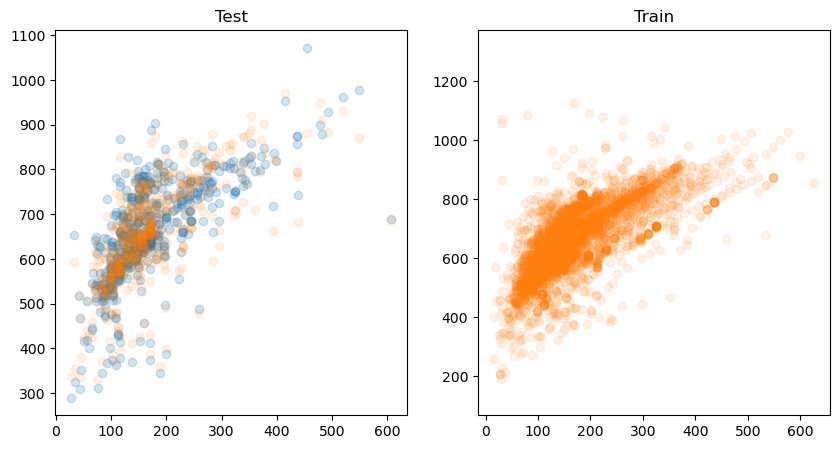

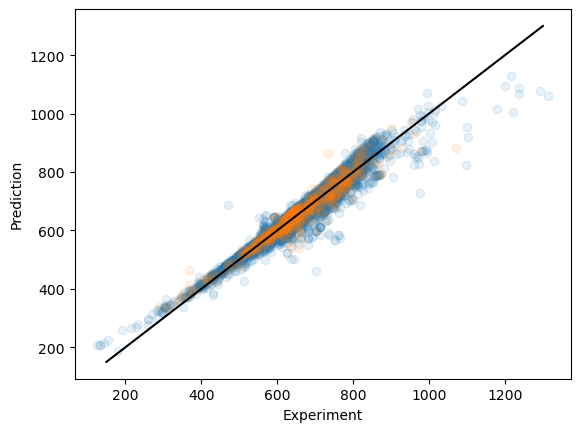

In [74]:
import sklearn
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Create linear regression object
regr = LinearRegression()

# Then, fit the regression to the training data
# So, let's define these variables
X_train = Train[['molweight','boiling point (K)','acentric factor']]
y_train = Train['critical temperature (K)']

X_test = Test[['molweight','boiling point (K)','acentric factor']]
y_test = Test['critical temperature (K)']
# scikit-learn takes uses the syntax regr.fit(X,y) where X is a 2D array, and y is a 1D array
# That's why Train[['molweight','boiling point (K)','acentric factor']] has two sets of brackets, and Train['critical temperature (K)'] only has one
regr.fit(X_train,y_train)

# Take a look at the coefficients
print(regr.coef_)

pred_train = regr.predict(X_train)
pred_test = regr.predict(X_test)

# The mean squared error
print('Training mean squared error: %.2f K^2'
      % mean_squared_error(y_train,pred_train))
print('Test mean squared error: %.2f K^2'
      % mean_squared_error(y_test,pred_test))

# The root mean squared error
print('Training root mean squared error: %.2f K'
      % mean_squared_error(y_train,pred_train,squared=False))
print('Test root mean squared error: %.2f K'
      % mean_squared_error(y_test,pred_test,squared=False))


fig, ax = plt.subplots(1,2,figsize=(10,5))

ax[0].scatter(Test['molweight'],Test['critical temperature (K)'],alpha=0.2)
ax[0].scatter(Test['molweight'],pred_test,alpha=0.1)
ax[0].set_title('Test')

ax[1].scatter(Train['molweight'],Train['critical temperature (K)'],alpha=0.)
ax[1].scatter(Train['molweight'],pred_train,alpha=0.1)
ax[1].set_title('Train')

fig.show

fig, ax = plt.subplots()

ax.scatter(Train['critical temperature (K)'],pred_train,alpha=0.1)
ax.scatter(Test['critical temperature (K)'],pred_test,alpha=0.1)
ax.plot(np.linspace(150,1300,10),np.linspace(150,1300,10),'k-') # This will give us a diagonal line
ax.set_xlabel('Experiment')
ax.set_ylabel('Prediction')

fig.show

**<font color=red> Problem </font>** Make a plotly figure for the parity plot, and add hovertext for the molecule names.

In [75]:
import plotly.graph_objects as go
fig1 = go.Figure()
fig1.add_trace(go.Scatter(x = Train['critical temperature (K)'], y= pred_train, text=Train['name'],mode='markers',
                         name = 'Train Data',  
               hovertemplate = '%{text} <extra></extra>'+'%{text}' + '<br>experimental crit temp(K)=%{x}'+ '<br>predicted crit temp (K)'))
fig1.add_trace(go.Scatter(x = Test['critical temperature (K)'], y= pred_test, text=Train['name'],mode='markers',
                          name = 'Test Data', 
                          hovertemplate = '%{text} <extra></extra>'+'%{text}' + '<br>experimental crit temp(K)=%{x}'+ '<br>predicted crit temp (K)'))
fig1.add_trace(go.Scatter(x = [0,1400], y= [0,1400],mode='lines'))
                       
fig1.show()

**<font color=red> Problem </font>** Identify some of the worst molecules. Record 5 molecule names here, along with the absolute error in their critical temperature. 

1)astatine,absolute error=272.0

2)sulfur,absolute error=254.7

3)ruthenium (V) fluoride,absolute error=248.9

4)4-octanecarboxylic acid,absolute error= 241.9

5)bismuth pentafluoride,absolute error= 217.4

In [76]:
def abserrorfunct(x, y):
    err= abs(x-y)
    return err 
ThermoProperties['absolute error']= abserrorfunct(Train['critical temperature (K)'],pred_train)
ThermoProperties['absolute error']. update(abserrorfunct(Test['critical temperature (K)'], pred_test))
print (ThermoProperties.nlargest(5, 'absolute error'))

                         name   molweight  critical temperature (K)  \
4127                 astatine  210.000000                   1096.37   
5687                   sulfur   32.066000                   1314.00   
5622   ruthenium (V) fluoride  196.062016                    977.44   
3744  4-octanecarboxylic acid  158.240720                    703.00   
4171    bismuth pentafluoride  303.972386                    470.00   

      acentric factor  boiling point (K)  absolute error  
4127           0.6410             607.00      271.970402  
5687           0.2463             717.82      254.695475  
5622           0.2960             500.15      248.888334  
3744           0.8310             358.15      241.856224  
4171           0.5040             503.15      217.457109  


**<font color=red> Problem </font>** How do the error metrics depend on the relative split between training and test set? Place 10, 20, 40, 80, 160, 320, 640, 1280, 2560, and 5120 molecules in the training set (the test set gets the remainder) and perform the regression for each one.

Tip: The cleanest solution will involve a function (or a few functions) that takes the dataframe and the training set size, and outputs the RMSE.

In [109]:
 from sklearn.model_selection import train_test_split
trainsizelist=[10,20,40,80,160,320,640,1280,2560,5120]
df= ThermoProperties
RMSEtrainlist=[]
RMSEtestlist=[]
overallRMSElist=[]
    
def linregfunc(df, trainsizelist):
    regress4 = LinearRegression()
    Train4, Test4 = train_test_split(df, train_size = trainsizelist)
    X_train4 =Train4[['molweight','boiling point (K)','acentric factor']]
    y_train4 =Train4['critical temperature (K)']
    X_test4 =Test4[['molweight','boiling point (K)','acentric factor']]
    y_test4 =Test4['critical temperature (K)']
    regress4.fit(X_train4,y_train4)
    predy_train4= regress4.predict(X_train4)
    predy_test4= regress4.predict(X_test4)
    global trainRMSE, testRMSE
    trainRMSE = mean_squared_error(y_train4, predy_train4, squared= False)
    testRMSE = mean_squared_error(y_test4, predy_test4, squared= False)
    
for i in range(0, len(trainsizelist)):
    linregfunc(df, trainsizelist[i])
    RMSEtrainlist.append(trainRMSE)
    RMSEtestlist.append(testRMSE)
    overallRMSElist.append('RMSE is {0} for train data, {1} for test data for train dataset size {2}'.format (round(trainRMSE, 3), round(testRMSE, 3), trainsizelist[i]))
print (np.reshape(overallRMSElist, (10,1)))
                    
    
    
    

[['RMSE is 10.771 for train data, 34.479 for test data for train dataset size 10']
 ['RMSE is 15.293 for train data, 34.364 for test data for train dataset size 20']
 ['RMSE is 23.837 for train data, 32.235 for test data for train dataset size 40']
 ['RMSE is 22.808 for train data, 27.505 for test data for train dataset size 80']
 ['RMSE is 40.227 for train data, 29.468 for test data for train dataset size 160']
 ['RMSE is 26.959 for train data, 27.464 for test data for train dataset size 320']
 ['RMSE is 23.79 for train data, 27.625 for test data for train dataset size 640']
 ['RMSE is 28.409 for train data, 26.877 for test data for train dataset size 1280']
 ['RMSE is 25.937 for train data, 28.137 for test data for train dataset size 2560']
 ['RMSE is 27.676 for train data, 23.987 for test data for train dataset size 5120']]


**<font color=red> Problem </font>** Using matplotlib, plot the RMSE for both training and test set (one subplot for each) as a function of training set size, giving the x axis a log scale.

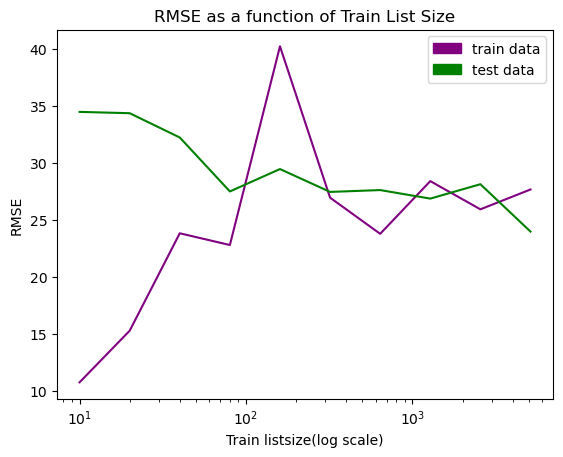

In [112]:
import matplotlib.patches as mpatches 
fig, ax=plt.subplots()
plt.plot(trainsizelist, RMSEtrainlist, color='purple')
plt.plot(trainsizelist, RMSEtestlist, color='green')
train02=mpatches.Patch(color='purple',label='train data')
test02=mpatches.Patch(color='green',label='test data')
ax.legend(handles =[train02,test02])
ax.set_xlabel('Train listsize(log scale)')
ax.set_xscale('log')
ax.set_ylabel('RMSE')
ax.set_title('RMSE as a function of Train List Size')
plt.show()






**<font color=orange> Deeper reading for those inspired: </font>** Read Chapter 3.1 of Dive Into Deep Learning: https://d2l.ai/chapter_linear-networks/linear-regression.html

Feel free to play around with code from that chapter

**<font color=orange> Extra Credit Problem: </font>** Implement linear regression on the ThermoProperties dataset using Pytorch.

**Get into this only if you think you're feeling rather comfortable with `sklearn` and want to take your ML implementation to the next level. Otherwise, don't worry about it.**

All the code you need to implement this is in Chapter 3.2 of Dive Into Deep Learning: https://d2l.ai/chapter_linear-networks/linear-regression-scratch.html

The example that is worked out in D2L is for a different problem. See if you can adapt the $\textbf{X}$ and $\textbf{y}$ variables in the example, and run the solution on the ThermoProperties dataset.

